### Setting Up

In [98]:
#fetching
import psycopg2
from sqlalchemy import create_engine

#wrangling
import numpy as np
import pandas as pd
import re
import copy
from collections import OrderedDict, defaultdict

#plotting
import matplotlib.pyplot as plt#, mpld3
import seaborn as sns

#storing
#import hdfs
import pickle
import json

#other
import time
import statsmodels

#ML
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
#from xgboost.sklearn import XGBClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV, train_test_split, learning_curve
from sklearn.metrics import roc_curve, confusion_matrix, roc_auc_score, precision_recall_curve,classification_report, f1_score, precision_score, recall_score,accuracy_score, make_scorer
from sklearn.cross_validation import cross_val_score
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.feature_selection import SelectPercentile, SelectKBest, f_regression, RFE, SelectFromModel, f_classif , chi2 
from sklearn.svm import SVC
from sklearn.decomposition import PCA

#### Load and Sample BTC Prices

In [100]:
import sqlite3
conn=sqlite3.connect("warehouse.db")
cur=conn.cursor()

fact_hourly_price_extract=pd.read_sql('SELECT * FROM fact_hourly_price_extract where type="bitcoin"',con=conn)
fact_hourly_price_extract.head()

df_btc_sample = fact_hourly_price_extract.sample(n=100)
df_btc_sample = df_btc_sample.sort_values(by='date')
df_btc_sample.date = pd.to_datetime(df_btc_sample['date'], format='%Y-%m-%dT%H:%M:%S')
df_btc_sample.head()

date 
 type 
 open 
 close 
 volumeto 
 volumefrom 
 high 
 low 
 
 
 
 
 102 
 2016-01-05 06:00:00 
 bitcoin 
 432.91 
 432.82 
 387391.95 
 894.18 
 433.31 
 432.12 
 
 
 281 
 2016-01-12 17:00:00 
 bitcoin 
 445.84 
 445.97 
 1185941.26 
 2654.35 
 446.80 
 445.32 
 
 
 305 
 2016-01-13 17:00:00 
 bitcoin 
 429.14 
 429.07 
 992036.83 
 2312.55 
 430.19 
 428.49 
 
 
 802 
 2016-02-03 10:00:00 
 bitcoin 
 374.87 
 375.07 
 794489.80 
 2118.56 
 375.82 
 374.46 
 
 
 1034 
 2016-02-13 02:00:00 
 bitcoin 
 386.30 
 386.02 
 1169135.58 
 3010.16 
 387.14 
 385.62

#### Load and Sample StockTwits Sentiments

In [101]:
df_stocktwits = pd.read_csv('stocktwits_hourly_sentiments_test.csv')
df_stocktwits.timestamp = pd.to_datetime(df_stocktwits['timestamp'], format='%Y-%m-%dT%H:%M:%S')
df_stocktwits_sample = df_stocktwits.sample(n=1000)
df_stocktwits_sample = df_stocktwits_sample.sort_values(by='timestamp')
df_stocktwits_sample.head()

timestamp 
 compound 
 pos 
 neg 
 count 
 
 
 
 
 0 
 2015-12-28 19:00:00 
 1.0000 
 1.000 
 0.000 
 1 
 
 
 29 
 2015-12-30 00:00:00 
 0.7983 
 0.404 
 0.000 
 1 
 
 
 52 
 2015-12-30 23:00:00 
 NaN 
 NaN 
 NaN 
 0 
 
 
 80 
 2016-01-01 03:00:00 
 0.7213 
 0.366 
 0.094 
 1 
 
 
 195 
 2016-01-05 22:00:00 
 0.7213 
 0.383 
 0.099 
 1

#### Scaling Both BTC and StockTwits series

In [102]:
from sklearn.preprocessing import scale
btc_dates = df_btc_sample["date"]
btc_price = df_btc_sample["open"]

stocktwits_dates = df_stocktwits_sample["timestamp"]
stocktwits_counts = df_stocktwits_sample["count"]

scaled_btc_price = scale(btc_price, axis=0, with_mean=True, with_std=True, copy=True)
scaled_stocktwits_counts = scale(stocktwits_counts, axis=0, with_mean=True, with_std=True, copy=True)

#### BTC Price and BTC Message Rate

Text(0,0.5,u'Normalized Values')

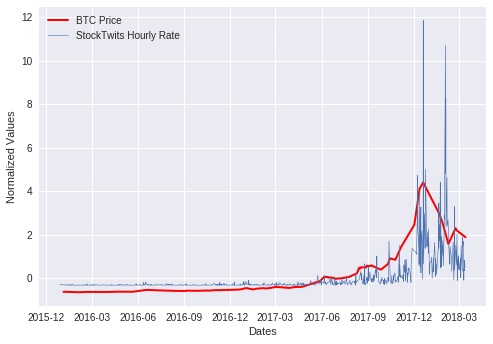

In [105]:
plt.plot(btc_dates, scaled_btc_price, label='BTC Price', linewidth=2, color='r')
plt.plot(stocktwits_dates, scaled_stocktwits_counts, label='StockTwits Hourly Rate', linewidth=0.60)
plt.legend(loc='best')
plt.xlabel('Dates')
plt.ylabel('Normalized Values')

#### BTC Price and Compound Sentiment

In [106]:
filtered_stocktwits_sample = df_stocktwits_sample[df_stocktwits_sample["pos"].notnull()]
stocktwits_compound = filtered_stocktwits_sample["pos"]
stocktwits_compound_dates = filtered_stocktwits_sample["timestamp"]

scaled_stocktwits_compound = scale(stocktwits_compound, axis=0, with_mean=True, with_std=True, copy=True)

Text(0,0.5,u'Normalized Values')

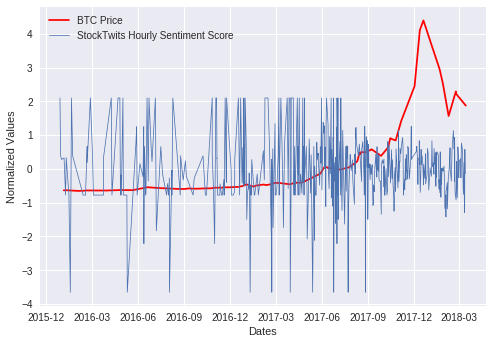

In [111]:
plt.plot(btc_dates, scaled_btc_price, label='BTC Price', color='r')
plt.plot(stocktwits_compound_dates, scaled_stocktwits_compound, label='StockTwits Hourly Sentiment Score', linewidth=0.75)
plt.legend(loc='best')
plt.xlabel('Dates')
plt.ylabel('Normalized Values')

#### Raw Hourly Normalized Sentiment Score

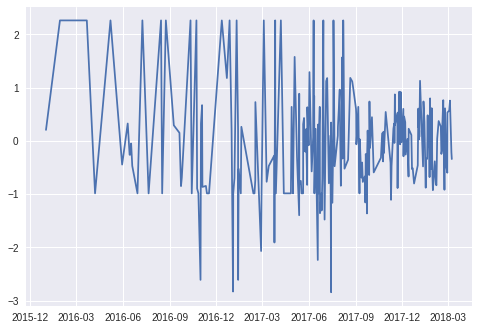

In [71]:
from scipy.interpolate import spline

#ynew = spline(stocktwits_compound_dates,scaled_stocktwits_compound,xnew)

plt.plot(stocktwits_compound_dates, scaled_stocktwits_compound, label='msg')

##### See the correlation of the dip for the crash between 2017 August and 2018 January on stocktweets hourly positive sentiment and BTC price above

#### BTC Price and Web Search Trends

In [47]:
import sqlite3
conn=sqlite3.connect("warehouse.db")
cur=conn.cursor()

fact_hourly_trend_extract=pd.read_sql('SELECT * FROM fact_hourly_trend_extract where type="bitcoin"',con=conn)

df_btc_trend = fact_hourly_trend_extract.sample(n=500)
df_btc_trend = df_btc_trend.sort_values(by='date')
df_btc_trend.date = pd.to_datetime(df_btc_trend['date'], format='%Y-%m-%dT%H:%M:%S')
df_btc_trend.head()

date 
 type 
 interest 
 
 
 
 
 79 
 2016-01-04 07:00:00 
 bitcoin 
 3 
 
 
 199 
 2016-01-09 07:00:00 
 bitcoin 
 4 
 
 
 263 
 2016-01-11 23:00:00 
 bitcoin 
 5 
 
 
 274 
 2016-01-12 10:00:00 
 bitcoin 
 3 
 
 
 349 
 2016-01-15 13:00:00 
 bitcoin 
 6

In [49]:
trend = df_btc_trend["interest"]
trend_dates = df_btc_trend["date"]

In [51]:
scaled_trend = scale(trend, axis=0, with_mean=True, with_std=True, copy=True)

Text(0,0.5,u'Normalized Values')

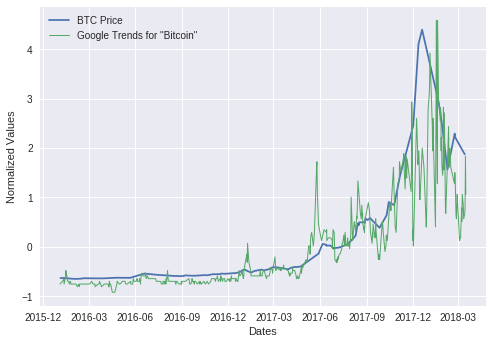

In [114]:
plt.plot(btc_dates, scaled_btc_price, label='BTC Price')
plt.plot(trend_dates, scaled_trend, label='Google Trends for "Bitcoin"', linewidth=1)
plt.legend(loc='best')
plt.xlabel('Dates')
plt.ylabel('Normalized Values')